<a href="https://colab.research.google.com/github/CompileWithG/MachineLearninMaterial/blob/main/heartbeat_classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# 1. Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber, CosineSimilarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [26]:
print(f"GPU:{tf.config.list_physical_devices('GPU')}, Platform:{platform.platform()}, Processor: {platform.machine()}")

GPU:[], Platform:Linux-6.1.85+-x86_64-with-glibc2.35, Processor: x86_64


In [27]:
# 2. Utility Functions
def predict(model, data):
    predictions = model.predict(data)
    loss = np.mean(np.abs(data - predictions), axis=1)
    return predictions, loss

def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label="Predicted")
    ax.fill_between(range(1, 189), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=7)
    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

def get_reconstruction_error(model, data):
    predictions = model.predict(data)
    return np.mean(np.abs(data - predictions), axis=1)

def classify_errors(errors, threshold):
    return np.array(errors > threshold, dtype=int)

In [28]:
# 3. Data Loading and Pre-processing
normal_df = pd.read_csv("ptbdb_normal.csv", sep=',').drop("target", axis=1, errors="ignore")
anomaly_df = pd.read_csv("ptbdb_abnormal.csv", sep=',').drop("target", axis=1, errors="ignore")

normal = normal_df.to_numpy()
anomaly = anomaly_df.to_numpy()
X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)


In [29]:
# 4. Model Definition
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


In [30]:
input_dim = X_train.shape[-1]
latent_dim = 32
epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)
loss_functions = {'MAE': MeanAbsoluteError(), 'MSE': MeanSquaredError(), 'Huber': Huber(), 'CosineSimilarity': CosineSimilarity()}

# Initialize with the first model (MAE) as default
initial_model = AutoEncoder(input_dim, latent_dim)
initial_model.build((None, input_dim))
if "macOS-13.5.2-arm64-arm-64bit" in platform.platform() and "arm64" in platform.machine():
    initial_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
                         loss=MeanAbsoluteError())
else:
    initial_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                         loss=MeanAbsoluteError())

best_model = initial_model
best_loss_function = 'MAE'
best_loss = float('inf')

# Now proceed with the training loop...

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_12', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [31]:
# Ground truth for validation
y_true_normal = np.zeros(len(X_test))
y_true_anomaly = np.ones(len(anomaly))
y_test = np.concatenate([y_true_normal, y_true_anomaly])
X_combined_test = np.concatenate([X_test, anomaly])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Using standard optimizer for conventional CPU.
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Validation Accuracy using MAE: 80.18%
Validation Reconstruction Error using MAE: 0.028784085496868804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


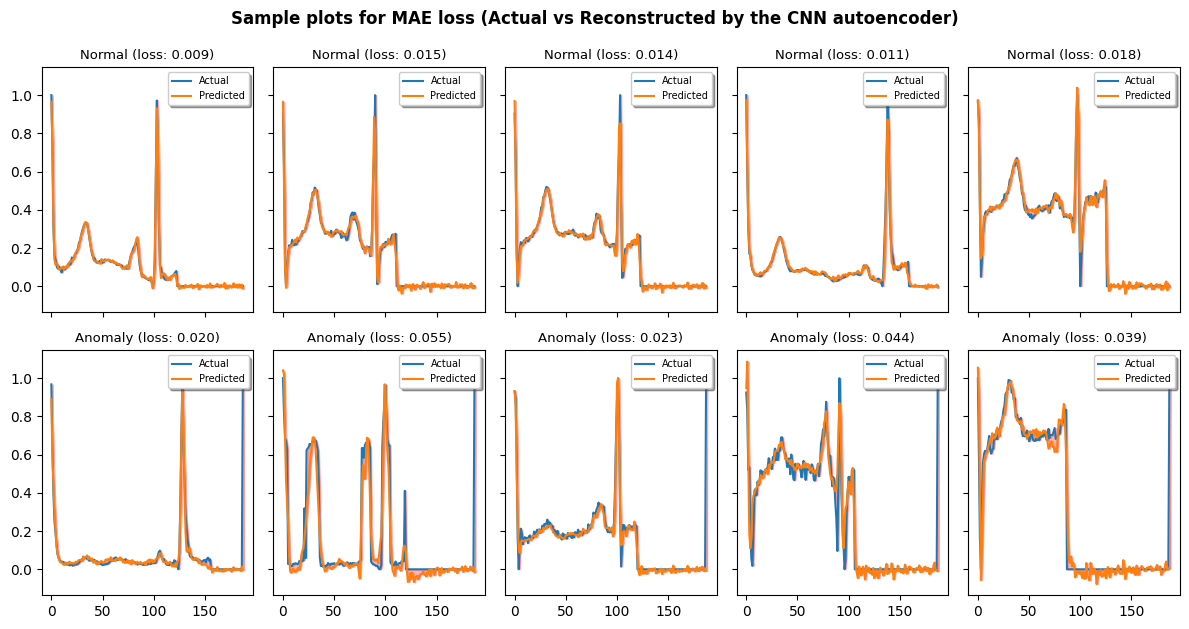

<AutoEncoder name=auto_encoder_13, built=True>
Using standard optimizer for conventional CPU.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Validation Accuracy using MSE: 70.98%
Validation Reconstruction Error using MSE: 0.04000444384754788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


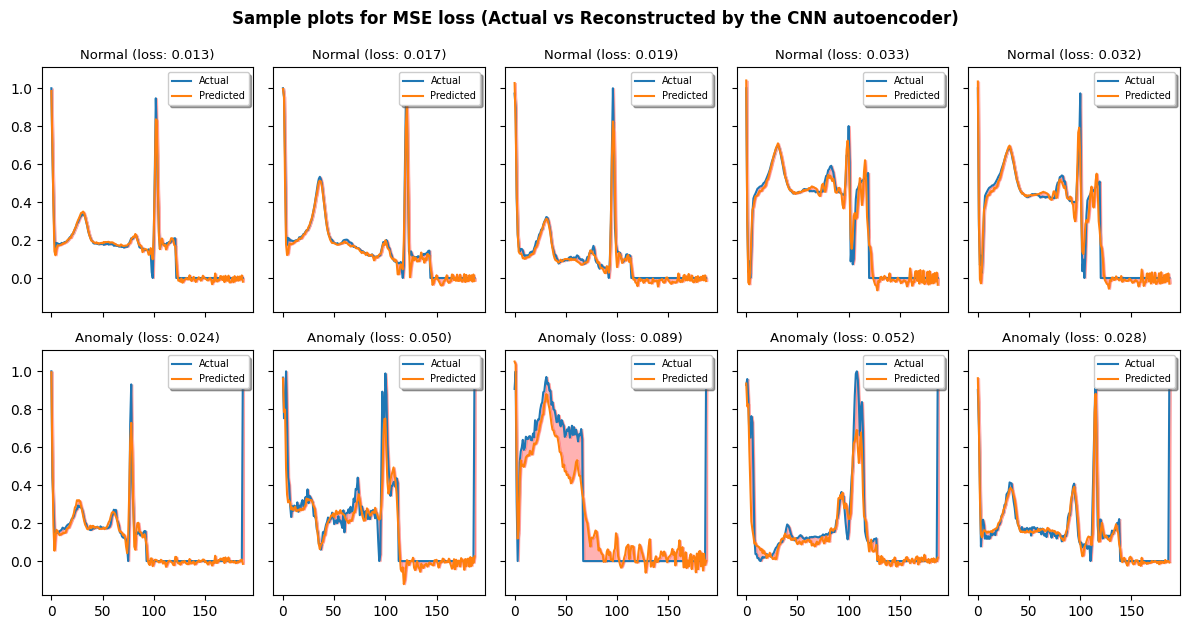

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Using standard optimizer for conventional CPU.
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Validation Accuracy using Huber: 72.51%
Validation Reconstruction Error using Huber: 0.0348624135517618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


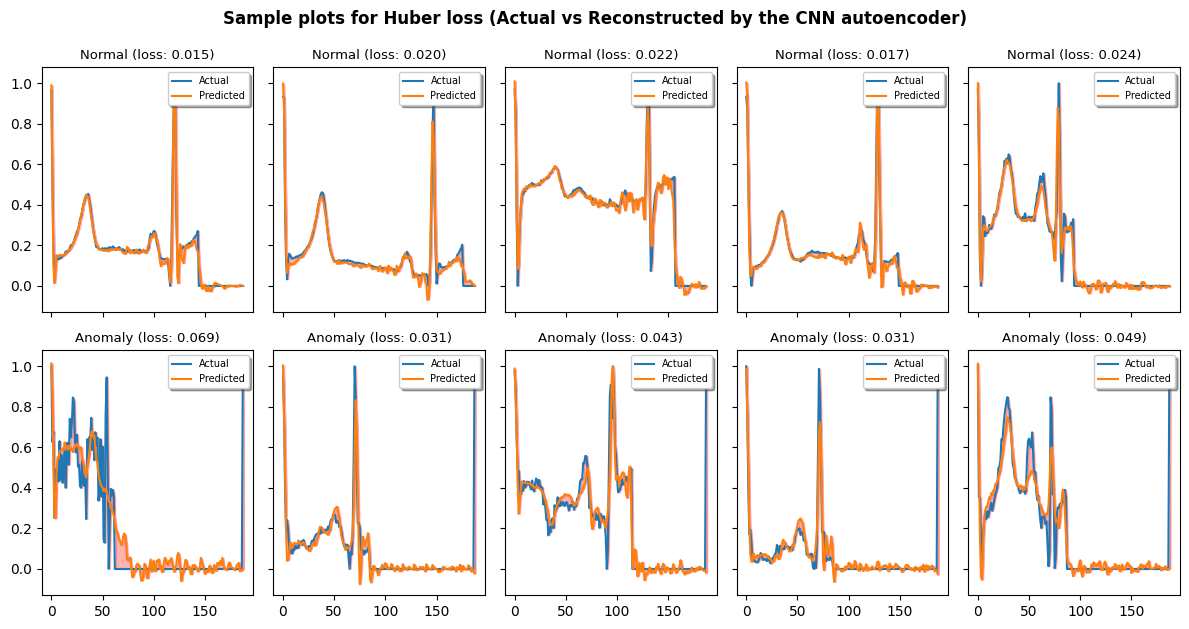

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'auto_encoder_16', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Using standard optimizer for conventional CPU.
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Validation Accuracy using CosineSimilarity: 16.45%
Validation Reconstruction Error using CosineSimilarity: 57.402556606452244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


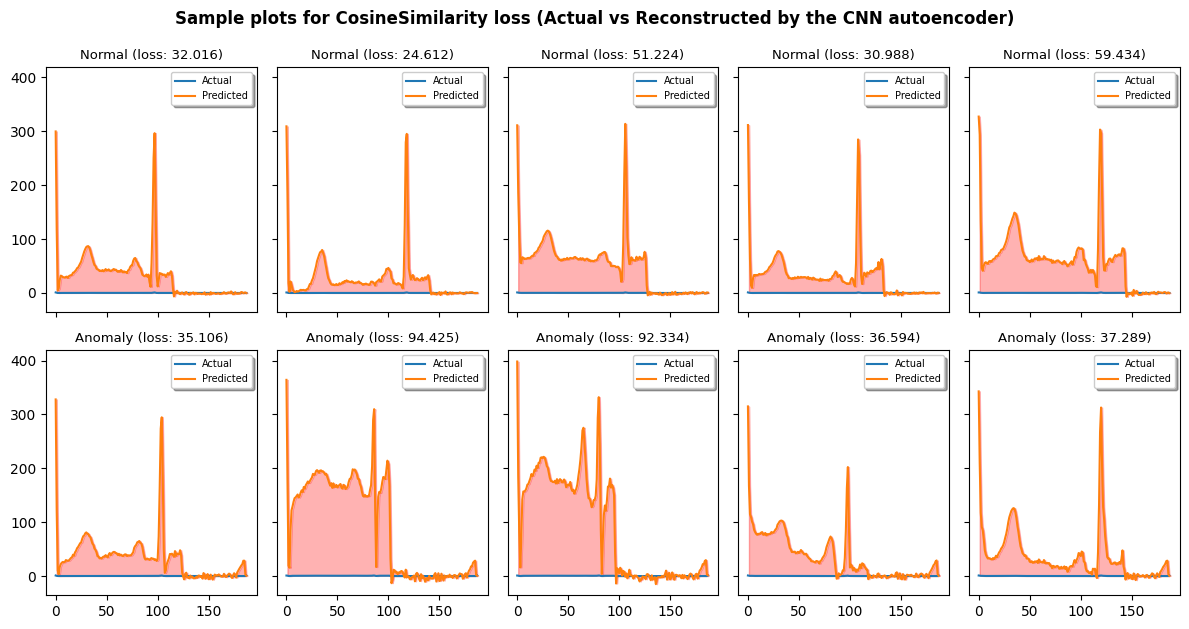

Best Model uses MAE with average validation error: 0.028784085496868804


In [32]:
# Train and evaluate models for each loss function
for name, loss_function in loss_functions.items():
    # Define and compile the model
    model = AutoEncoder(input_dim, latent_dim)
    model.build((None, input_dim))
    # Check if the machine is using an M1/M2 processor
    if "macOS-13.5.2-arm64-arm-64bit" in platform.platform() and "arm64" in platform.machine():
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), loss=loss_function)
        print("Using legacy optimizer for M1/M2 Mac.")
    elif tf.config.list_physical_devices('GPU'):  # Check if there are any GPUs available
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_function)
        print("Using standard optimizer for GPU.")
    else:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_function)
        print("Using standard optimizer for conventional CPU.")


    # Train the model
    model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
              validation_split=0.1, callbacks=[early_stopping], verbose=0)

    # Calculate the threshold based on the training data
    train_errors = get_reconstruction_error(model, X_train)
    threshold = np.percentile(train_errors, 95)  # 95th percentile as threshold

    # Evaluate the model on combined validation data (normal + anomaly) using the calculated threshold
    val_errors = get_reconstruction_error(model, X_combined_test)
    y_pred_val = np.array(val_errors > threshold, dtype=int)

    accuracy = accuracy_score(y_test, y_pred_val)

    print(f"Validation Accuracy using {name}: {accuracy:.2%}")
    print(f"Validation Reconstruction Error using {name}: {np.mean(val_errors)}")

    # After training, visualize the reconstructions for this specific model
    fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6))
    random_indexes = np.random.randint(0, len(X_train), size=5)
    for i, idx in enumerate(random_indexes):
        data = X_train[[idx]]
        plot_examples(model, data, ax=axes[0, i], title="Normal")
    for i, idx in enumerate(random_indexes):
        data = anomaly[[idx]]
        plot_examples(model, data, ax=axes[1, i], title="Anomaly")
    plt.tight_layout()
    fig.suptitle(f"Sample plots for {name} loss (Actual vs Reconstructed by the CNN autoencoder)", y=1.04, weight="bold")
    plt.show()

    # Check if current model is the best
    if np.mean(val_errors) < best_loss:
        best_loss = np.mean(val_errors)
        best_model = model
        print(best_model)
        best_loss_function = name

print(f"Best Model uses {best_loss_function} with average validation error: {best_loss}")

In [33]:
# 6. Evaluation
threshold = np.percentile(get_reconstruction_error(best_model, X_train), 95)
normal_errors = get_reconstruction_error(best_model, X_test)
anomaly_errors = get_reconstruction_error(best_model, anomaly)
y_pred_normal = classify_errors(normal_errors, threshold)
y_pred_anomaly = classify_errors(anomaly_errors, threshold)
y_true_normal = np.zeros_like(y_pred_normal)
y_true_anomaly = np.ones_like(y_pred_anomaly)
y_pred = np.concatenate([y_pred_normal, y_pred_anomaly])
y_true = np.concatenate([y_true_normal, y_true_anomaly])
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Accuracy: 80.18%
Precision: 99.56%
Recall: 79.39%
F1 Score: 88.34%


Text(0.5, 36.72222222222221, 'Predicted Class')

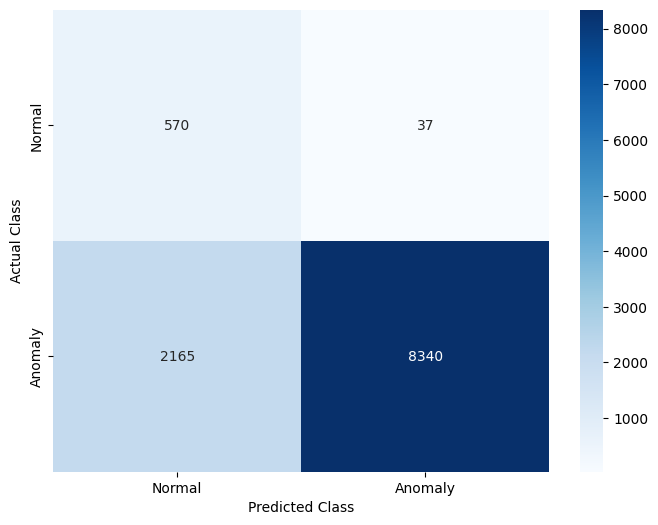

In [34]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')